## Нейронные сети: зависимость ошибки и обучающей способности от числа нейронов

Для решения задачи многоклассовой классификации при помощи двуслойной нейронной сети будет использована библиотека построения нейронных сетей [pybrain](http://pybrain.org/). Библиотека содержит основные модули инициализации двуслойной нейронной сети прямого распространения, оценки ее параметров с помощью метода обратного распространения ошибки (backpropagation) и подсчета ошибки.

###  Используемые данные

Рассматривается задача оценки качества вина по его физико-химическим свойствам [1]. Данные размещены в [открытом доступе](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в репозитории UCI  и содержат 1599 образцов красного вина, описанных 11 признаками, среди которых -- кислотность, процентное содержание сахара, алкоголя и пр. Кроме того, каждому объекту поставлена в соответствие оценка качества по шкале от 0 до 10. Требуется восстановить оценку качества вина по исходному признаковому описанию.

[1] P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.  In Decision Support Systems, Elsevier, 47(4):547-553, 2009. 

In [23]:
# Выполним инициализацию основных используемых модулей
%matplotlib inline

import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import numpy as np

Выполним загрузку данных

In [9]:
with open('8. Двуслойные нейронные сети в задачах классификации.csv') as f:
    f.readline()  # пропуск заголовочной строки
    data = np.loadtxt(f, delimiter=';')

В качестве альтернативного варианта, можно выполнить загрузку данных напрямую из репозитория UCI, воспользовавшись библиотекой urllib.

In [7]:
import urllib
# URL for the Wine Quality Data Set (UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# загрузка файла
f = urllib.request.urlopen(url)
f.readline()  # пропуск заголовочной строки
data = np.loadtxt(f, delimiter=';')

In [18]:
# Соотношение классов целевой переменной
for i in sorted(set(data[:, -1])):
    print(f'{i} - {(data[:, -1][data[:, -1] == i].shape[0] / data[:, -1].shape[0] * 100):.2f}%')

3.0 - 0.63%
4.0 - 3.31%
5.0 - 42.59%
6.0 - 39.90%
7.0 - 12.45%
8.0 - 1.13%


Выделим из данных целевую переменную. Классы в задаче являются несбалинсированными: основной доле объектов поставлена оценка качества от 5 до 7. Приведем задачу к трехклассовой: объектам с оценкой качества меньше пяти поставим оценку 5, а объектам с оценкой качества больше семи поставим 7. 

In [24]:
TRAIN_SIZE = 0.7 # Разделение данных на обучающую и контрольную части в пропорции 70/30%

# Целевая переменная
y = data[:, -1]

# Заменить в массиве y все объекты, удовлетворяющие условию y < 5 на значение 5
np.place(y, y < 5, 5)

# Заменить в массиве y все объекты, удовлетворяющие условию y > 7 на значение 7
np.place(y, y > 7, 7)

# Вычесть из каждого значения в массиве y минимальное значение в массиве (отнормировать значения от 0 до max(y)-min(y))
y -= min(y)

# Пространство признаков
X = data[:, :-1]

# Нормировка пространства признаков
X = normalize(X)

# Разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=0)

In [26]:
# Соотношение классов нормированной целевой переменной
for i in sorted(set(y)):
    print(f'{i} - {(y[y == i].shape[0] / y.shape[0] * 100):.2f}%')

0.0 - 46.53%
1.0 - 39.90%
2.0 - 13.57%


In [28]:
# Соотношение классов нормированной целевой переменной в обучающей выборке
for i in sorted(set(y_train)):
    print(f'{i} - {(y_train[y_train == i].shape[0] / y_train.shape[0] * 100):.2f}%')

0.0 - 46.29%
1.0 - 38.78%
2.0 - 14.92%


In [29]:
# Соотношение классов нормированной целевой переменной в тестовой выборке
for i in sorted(set(y_test)):
    print(f'{i} - {(y_test[y_test == i].shape[0] / y_test.shape[0] * 100):.2f}%')

0.0 - 47.08%
1.0 - 42.50%
2.0 - 10.42%


### Двуслойная нейронная сеть

Двуслойная нейронная сеть представляет собой функцию распознавания, которая може быть записана в виде следующей суперпозиции:

$$f(x,W)=h^{(2)}\left(\sum\limits_{i=1}^D w_i^{(2)}h^{(1)}\left(\sum\limits_{j=1}^n w_{ji}^{(1)}x_j+b_i^{(1)}\right)+b^{(2)}\right)$$

где

* $x$ - исходный объект (сорт вина, описанный 11 признаками), 

* $x_j$ - соответствующий признак,

* $n$ -  количество нейронов во входном слое сети, совпадающее с количеством признаков,

* $D$ -  количество нейронов в скрытом слое сети,

* $w_i^{(2)}, w_{ji}^{(1)}, b_i^{(1)}, b^{(2)}$ -  параметры сети, соответствующие весам нейронов,

* $h^{(1)}, h^{(2)}$ - функции активации.

В качестве функции активации на скрытом слое сети используется линейная функция. На выходном слое сети используется функция активации softmax, являющаяся обобщением сигмоидной функции на многоклассовый случай:

$$y_k=\text{softmax}_k(a_1,...,a_k)=\frac{\exp(a_k)}{\sum_{k=1}^K\exp(a_k)}$$



### Настройка параметров сети

Оптимальные параметры сети $W_{opt}$ определяются путем минимизации функции ошибки:

$$W_{opt}=\arg\min\limits_{W}L(W)+\lambda\|W\|^2$$

Здесь $L(W)$ является функцией ошибки многоклассовой классификации,

$$L(W)=- \sum^N_{n=1}\sum^K_{k=1} t_{kn} log(y_{kn})$$

* $t_{kn}$ - бинарно закодированные метки классов, 

* $K$ - количество меток, 

* $N$ - количество объектов,

* $\lambda\|W\|^2$ - регуляризующее слагаемое, контролирующее суммарный вес параметров сети и предотвращающее эффект переобучения.

Оптимизация параметров выполняется методом обратного распространения ошибки (backpropagation).

Выполним загрузку основных модулей: 
* ClassificationDataSet - структура данных pybrain, 
* buildNetwork - инициализация нейронной сети, 
* BackpropTrainer - оптимизация параметров сети методом backpropagation, 
* SoftmaxLayer - функция softmax, соответствующая выходному слою сети, 
* LinearLayer - линейная функция активации, оотвествующая скрытому слою,
* percentError - функция подсчета ошибки классификации (доля неправильных ответов). 

In [87]:
from pybrain.datasets import ClassificationDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer, LinearLayer
from pybrain.utilities import percentError

Инициализируем основные параметры задачи: 
* HIDDEN_NEURONS_NUM - количество нейронов скрытого слоя, 
* MAX_EPOCHS - максимальное количество итераций алгоритма оптимизации

In [88]:
# Определение основных констант
HIDDEN_NEURONS_NUM = 100 # Количество нейронов, содержащееся в скрытом слое сети
MAX_EPOCHS = 100 # Максимальное число итераций алгоритма оптимизации параметров сети

Инициализируем структуру данных ClassificationDataSet, используемую библиотекой pybrain. Для инициализации структура принимает два аргумента: 
* количество признаков *np.shape(X)[1]* 
* количество различных меток классов *len(np.unique(y))*.

Кроме того, произведем бинаризацию целевой переменной с помощью функции *_convertToOneOfMany( )* и разбиение данных на обучающую и контрольную части.

In [89]:
# Конвертация данных в структуру ClassificationDataSet
# Обучающая часть
ds_train = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
# Первый аргумент -- количество признаков np.shape(X)[1], второй аргумент -- количество меток классов len(np.unique(y_train)))
ds_train.setField('input', X_train) # Инициализация объектов
ds_train.setField('target', y_train[:, np.newaxis]) # Инициализация ответов; np.newaxis создает вектор-столбец
ds_train._convertToOneOfMany( ) # Бинаризация вектора ответов
# Контрольная часть
ds_test = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', X_test)
ds_test.setField('target', y_test[:, np.newaxis])
ds_test._convertToOneOfMany( )

Инициализируем двуслойную сеть и произведем оптимизацию ее параметров. Аргументами для инициализации являются:

* ds.indim - количество нейронов на входном слое сети, совпадает с количеством признаков (в нашем случае 11),

* HIDDEN_NEURONS_NUM - количество нейронов в скрытом слое сети,

* ds.outdim - количество нейронов на выходном слое сети, совпадает с количеством различных меток классов (в нашем случае 3),

* SoftmaxLayer - функция softmax, используемая на выходном слое для решения задачи многоклассовой классификации.

In [91]:
np.random.seed(0) # Зафиксируем seed для получения воспроизводимого результата

# Построение сети прямого распространения (Feedforward network)
net = buildNetwork(ds_train.indim, HIDDEN_NEURONS_NUM, ds_train.outdim, outclass=SoftmaxLayer, hiddenclass = LinearLayer)
# ds.indim -- количество нейронов входного слоя, равне количеству признаков
# ds.outdim -- количество нейронов выходного слоя, равное количеству меток классов
# SoftmaxLayer -- функция активации, пригодная для решения задачи многоклассовой классификации

init_params = np.random.random((len(net.params))) # Инициализируем веса сети для получения воспроизводимого результата
net._setParameters(init_params)

 Выполним оптимизацию параметров сети. График ниже показывает сходимость функции ошибки на обучающей/контрольной части.

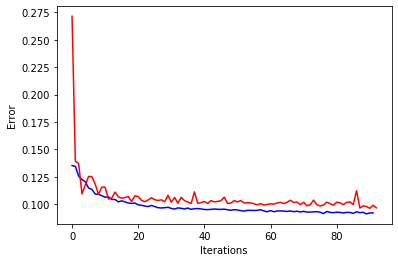

In [92]:
random.seed(0)
# Модуль настройки параметров pybrain использует модуль random; зафиксируем seed для получения воспроизводимого результата
trainer = BackpropTrainer(net, dataset=ds_train) # Инициализируем модуль оптимизации
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
line_train = plt.plot(err_train, 'b', err_val, 'r') # Построение графика
xlab = plt.xlabel('Iterations')
ylab = plt.ylabel('Error')

Рассчитаем значение доли неправильных ответов на обучающей и контрольной выборке.

In [93]:
# Подсчет результата на обучающей выборке
res_train = net.activateOnDataset(ds_train).argmax(axis=1)

# Подсчет ошибки
print(f'Error on train: {(percentError(res_train, ds_train["target"].argmax(axis=1))):.3f} %')

# Подсчет результата на тестовой выборке
res_test = net.activateOnDataset(ds_test).argmax(axis=1) 

# Подсчет ошибки
print(f'Error on test: {(percentError(res_test, ds_test["target"].argmax(axis=1))):.3f} %') 

Error on train: 44.057 %
Error on test: 43.958 %


### Определение оптимального числа нейронов.
Исследуем зависимость ошибки на контрольной выборке в зависимости от числа нейронов в скрытом слое сети. 

Исследуемое количество нейронов, по которому предполагается провести перебор, записано в векторе:
```
hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
```

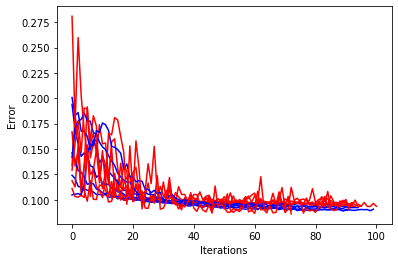

In [94]:
random.seed(0) # Зафиксируем seed для получния воспроизводимого результата
np.random.seed(0)

# Массив, содержащий количество нейронов, по которому предполагается провести перебор
hidden_neurons_num = [50, 100, 200, 500, 700, 1000]

# Массив, содержащий значения доли неправильных ответов классификации на обучении
res_train_vec = list()
# Массив, содержащий значения доли неправильных ответов классификации на контроле
res_test_vec = list()

for nnum in hidden_neurons_num:
    net = buildNetwork(ds_train.indim, nnum, ds_train.outdim, outclass=SoftmaxLayer, hiddenclass = LinearLayer)
    init_params = np.random.random((len(net.params)))
    net._setParameters(init_params)
    
    # Модуль настройки параметров pybrain использует модуль random;
    trainer = BackpropTrainer(net, dataset=ds_train) # Инициализируем модуль оптимизации
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs=MAX_EPOCHS)
    
    # Подсчет результата на обучающей выборке
    res_train = net.activateOnDataset(ds_train).argmax(axis=1)
    # Подсчет ошибки
    res_train_vec.append(percentError(res_train, ds_train["target"].argmax(axis=1)))

    # Подсчет результата на тестовой выборке
    res_test = net.activateOnDataset(ds_test).argmax(axis=1) 
    # Подсчет ошибки 
    res_test_vec.append(percentError(res_test, ds_test["target"].argmax(axis=1)))      

In [95]:
for x, y, z in zip(hidden_neurons_num, res_train_vec, res_test_vec):
    print(f'{x} newrons: \ttrain error - {y:.3f}%, \n\t\ttest error - {z:.3f}%')

50 newrons: 	train error - 47.900%, 
		test error - 43.125%
100 newrons: 	train error - 44.325%, 
		test error - 41.042%
200 newrons: 	train error - 43.521%, 
		test error - 42.083%
500 newrons: 	train error - 39.946%, 
		test error - 37.708%
700 newrons: 	train error - 42.002%, 
		test error - 35.000%
1000 newrons: 	train error - 41.197%, 
		test error - 35.625%


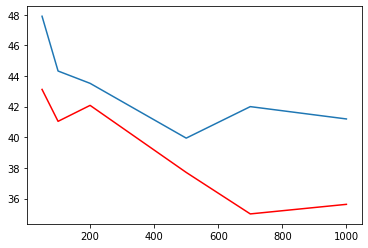

In [96]:
def plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec):
    plt.figure()
    plt.plot(hidden_neurons_num, res_train_vec)
    plt.plot(hidden_neurons_num, res_test_vec, '-r')


# График зависимости ошибок на обучении и контроле в зависимости от количества нейронов
plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec)  

In [98]:
#  Количество нейронов, при котором достигается минимум ошибки на контроле
hidden_neurons_num[res_test_vec.index(min(res_test_vec))]

700